# Text Classifier Application using Machine Learning

In this notebook, the goal is to build a system such that the user enters some text (for example, a sentence) and the systems outputs either “Sport”, “Science”, or “Business” (whichever more appropriate) as the class of the input text.

The dataset is available on kaggle.com.<br>
<a href= 'https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset?resource=download'> dataset link</a>

It has two files; <i>train.csv</i> and <i>test.csv.</i><br>
In this notebook we use <i>train.csv</i> as the data to train and test the model.<br><br>
At the end, we will use the <i>test.csv</i> as unseen data to see the accuracy of the model.

<i>Please note that I have only created a Multinomial Naive Bayes model as this algorithm is suitable for text classification problem in Natural Language Processing.</i>

### Import Required Libraries

In [1]:
# Data processing and EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
import re
import nltk
# nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Model validation
from sklearn.model_selection import train_test_split

# Model Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

# Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling
from sklearn.naive_bayes import MultinomialNB

# To filter Warnings
import warnings
warnings.filterwarnings('ignore')

# 1. Data

Read the data.

In [2]:
data = pd.read_csv("AG_News_Archive/train.csv")

Check the total number of rows and columns.

In [3]:
data.shape

(120000, 3)

There are 120,000 records and 3 columns.

Check the data head.

In [4]:
data.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


Check data info.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


There is no missing value.

Check the unique labels for 'Class Index' column and its counts.

In [6]:
data['Class Index'].unique()

array([3, 4, 2, 1])

In [7]:
data['Class Index'].value_counts()

3    30000
4    30000
2    30000
1    30000
Name: Class Index, dtype: int64

According to the dataset provider, the 'Class Index' consists of class ids 1-4 where,<br><br>
1 - World,<br>2 - Sports, <br>3 - Business, <br>4 - Sci/Tech

# 2. Data Pre-processing

In this notebook, we going to predict whether a given input is "Sports, Science or Business" text.<br>
Therefore, we only select the records of our interest (i.e. removing "World" labelled records).

In [8]:
data = data[data['Class Index'] != 1]

Check the labels.

In [9]:
data['Class Index'].unique()

array([3, 4, 2])

Now, let's encode the labels as the following:<br><br>
Sports: 0, <br>
Science: 1, <br>
Business: 2<br>

Consists of class ids 1-4 where 1-World, 2-Sports, 3-Business, 4-Sci/Tech

In [10]:
# creating an encoder function
def encode(label):
    if label == 2:
        return 0
    elif label == 3:
        return 2
    else:
        return 1

In [11]:
data['Class Index'] = data['Class Index'].apply(encode)

Check the labels.

In [12]:
data['Class Index'].unique()

array([2, 1, 0])

Now, let us make the data clean by creating columns 'text' and 'target' only.

In [13]:
# combine 'Title' and 'Description'
data['text'] = data['Title']+ ' ' + data['Description']

In [14]:
# create a new column 'target' from 'Class Index'
data['target'] = data['Class Index']

In [15]:
# remove the columns 'Class Index', 'Title', and 'Description'
data = data.drop(columns = ['Class Index', 'Title', 'Description'])

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90000 entries, 0 to 119999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    90000 non-null  object
 1   target  90000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.1+ MB


Check the data.

In [17]:
data.head()

,text,target
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [18]:
data.target.value_counts()

2    30000
1    30000
0    30000
Name: target, dtype: int64

<AxesSubplot:xlabel='target', ylabel='count'>

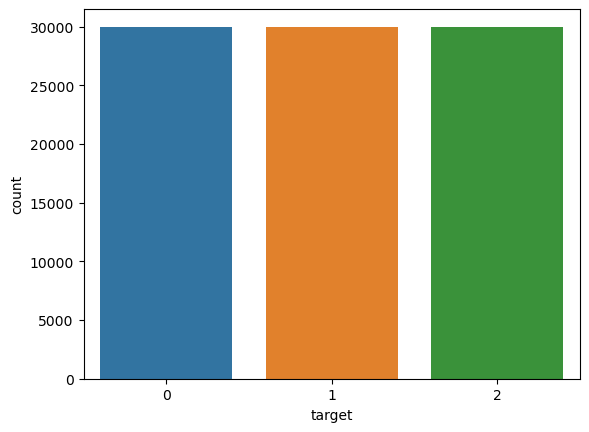

In [19]:
sns.countplot("target", data=data)

The data looks good now, and the target variable has balanced class.

For the text preprocessing, I have created a function which removes special characters, stop words and lemmatize the words.

In [20]:
def preprocessText(text):
    # lowercase
    text = text.lower()
    
    # remove special characters, punctuations and numbers
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # tokenize into words
    words = text.split()

    # remove stop words
    sw = stopwords.words('english')
    words = [word for word in words if word not in sw]
    
    # lemmatizer
    lemmatizer = WordNetLemmatizer()
    words = [(lemmatizer.lemmatize(word)) for word in words]

    # join the processed words back into a single string
    processed_text = " ".join(words)

    return processed_text


Preprocess the text data.

In [21]:
data.text = data.text.apply(preprocessText)

Divide the data into input(X) and target(y).

In [22]:
X = data.text
y = data.target

Divide the data into Train and Test.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
# 20% data as test

Vectorize the text data.

In [24]:
vectorizer = TfidfVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

Note that we fit and transform the X_train while only transform the X_test data.

# 3. Modeling

Creating Multinomial Naive Bayes model as this algorithm is suitable for text classification problem in Natural Language Processing.

In [25]:
model = MultinomialNB()
model.fit(X_train_vectors, y_train)

MultinomialNB()

In [26]:
model.score(X_test_vectors, y_test)

0.9333888888888889

The model score is 93.33% which is a good score.

<Figure size 600x600 with 0 Axes>

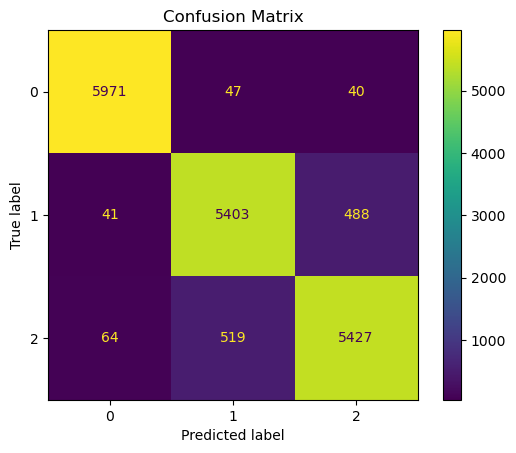

In [27]:
# Confusion Matrix

plt.figure(figsize = (6,6))

ConfusionMatrixDisplay.from_estimator(model, X_test_vectors, y_test)
plt.title('Confusion Matrix')

plt.show()

The model is basically misclassifying between science and business.<br>
Note: <br>
Sports: 0, 
Science: 1, 
Business: 2

# 4. Model Evaluation

We now evaluate the model using <i>test.csv</i> file.<br>
Note that the <i>test.csv</i> file is not used until now.

Repeat all the steps we have done above.

In [28]:
# for testing
test_data = pd.read_csv("AG_News_Archive/test.csv")
# remove "World" data
test_data = test_data[test_data['Class Index'] != 1]
# encode the "Class Index"
test_data['Class Index'] = test_data['Class Index'].apply(encode)
# combine 'Title' and 'Description'
test_data['text'] = test_data['Title']+ ' ' + test_data['Description']
# create a new column 'target' from 'Class Index'
test_data['target'] = test_data['Class Index']
# remove the columns 'Class Index', 'Title', and 'Description'
test_data = test_data.drop(columns = ['Class Index', 'Title', 'Description'])
# preprocess the text data
test_data.text = test_data.text.apply(preprocessText)
# Divide the data into input(X) and target(y).
test_data_X = test_data.text
test_data_y = test_data.target
# vectorize using above used vectorizer
test_data_X_vectors = vectorizer.transform(test_data_X)
# calculate model score on unseen data
model.score(test_data_X_vectors, test_data_y)

0.9250877192982456

The score on unseen data is 92.50% which is slightly less than the score on train data. But this score is very good.

<Figure size 600x600 with 0 Axes>

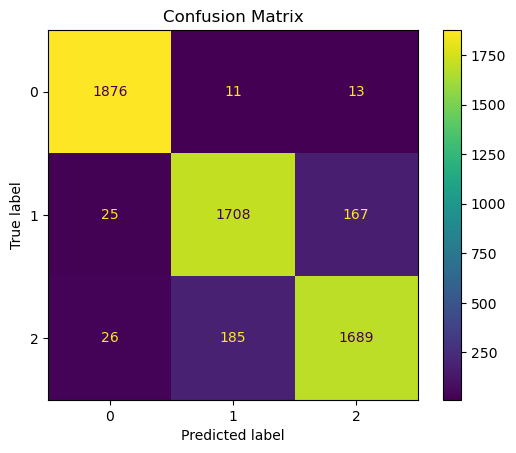

In [29]:
# Confusion Matrix

plt.figure(figsize = (6,6))

ConfusionMatrixDisplay.from_estimator(model, test_data_X_vectors, test_data_y)
plt.title('Confusion Matrix')

plt.show()

The model is basically misclassifying between science and business.<br>
Note: <br>
Sports: 0, 
Science: 1, 
Business: 2

# 5. Implementation

Let's create a function to process the input and return the output.

In [30]:
def result(query):
    '''
    This function take in the query as the input and returns the predicted label.
    Returns Sports, Science or Business text.
    '''
    processed_query = preprocessText(query)
    
    if len(processed_query) != 0:
        processed_query = [processed_query]
        processed_query_vector = vectorizer.transform(processed_query)
        result = model.predict(processed_query_vector)
        if result == 0:
            return 'Sports'
        elif result == 1:
            return 'Science'
        else:
            return 'Business'
    else:
        return 'Invalid search'

# 6. Test

In [31]:
# when the input is empty
result('')

'Invalid search'

In [32]:
# when the input is just number
result('1234567890')

'Invalid search'

In [33]:
# stop words
result('they are')

'Invalid search'

In [34]:
# special characters
result("{everyone in england likes WIMBLEDON!!!}")

'Sports'

In [35]:
result('i love football and basketball')

'Sports'

In [36]:
result("why can't humans dream of using a cell phone")

'Science'

In [37]:
result('how much money is too much money?')

'Business'

In [38]:
# https://www.bbc.co.uk/news/business-66309002#
result("""China has named Pan Gongsheng as the new governor of its central bank, the People's Bank of China (PBOC).
The 60-year-old's appointment comes as the country continues to struggle with major economic challenges in the wake of the coronavirus pandemic.
Among the problems facing the world's second largest economy are slowing growth, a housing market in crisis and youth unemployment at a record high.
Mr Pan succeeds Yi Gang, who held the top post at the PBOC since 2018.""")

'Business'

In [39]:
# https://www.bbc.co.uk/news/science-environment-66289489#
result("""The heatwaves battering Europe and the US in July would have been "virtually impossible" without human-induced climate change, a scientific study says.
Global warming from burning fossil fuels also made the heatwave affecting parts of China 50 times more likely.
Climate change meant the heatwave in southern Europe was 2.5C hotter, the study finds.
Almost all societies remain unprepared for deadly extreme heat, experts warn.
The study's authors say its findings highlight the importance of the world adapting to higher temperatures because they are no longer "rare".
"Heat is among the deadliest types of disaster," says Julie Arrighi from the Red Cross Red Crescent Climate Centre, and also one of the authors.
Countries must build heat-resistant homes, create "cool centres" for people to find shelter, and find ways to cool cities including planting more trees, she says.
In July, temperature records were broken in parts of China, the southern US and Spain. Millions of people spent days under red alerts for extreme heat.
Experts say extreme heat can be a very serious threat to life, especially among the elderly. According to one study, more than 61,000 people were estimated to have died from heat-related causes during last year's heatwaves in Europe.
"This study confirms what we knew before. It shows again just how much climate change plays a role in what we are currently experiencing," said Friederike Otto from Imperial College London.
Climate scientists say decades of humans pumping greenhouse gases into the atmosphere are causing global temperatures to rise.
But not all extreme weather events can immediately be linked directly to climate change because natural weather patterns can also play a part.
Scientists in the UK, US and Netherlands in the World Weather Attribution group studied the recent heatwaves to identify the fingerprint of climate change.""")

'Science'

In [40]:
# this is a sport news
# https://www.bbc.co.uk/news/world-us-canada-66274633
result("""Tottenham Hotspur owner Joe Lewis has been charged with "orchestrating a brazen insider trader scheme", US attorney Damian Williams has said.
Mr Williams used a video announcement to accuse the British billionaire of using inside information to "shower gifts on his friends and lovers".
Mr Lewis "has been indicted and will face justice" in the Southern District of New York (SDNY), Mr Williams said.
BBC News has approached Tottenham Hotspur and Mr Lewis for comment.
In the video statement, posted on Twitter, Mr Williams set out a series of allegations against Mr Lewis. A formal written statement, known as an indictment, has yet to be released.
"We allege that, for years, Joe Lewis abused his access to corporate board rooms and repeatedly provided inside information to his romantic partners, his personal assistants, his private pilots, and his friends," Mr Williams said in the video.
Mr Williams, the chief federal law enforcement officer for the SDNY, alleged that Mr Lewis's acquaintances used that information to make millions of dollars in the stock market.
"Thanks to [Mr] Lewis, those bets were a sure thing," he claimed.
Mr Lewis owns hundreds of assets, including Premier League London club Spurs and a stake in UK pub chain Mitchells & Butlers. Forbes magazine has recently estimated his fortune at £4.73bn ($6.1bn).""")

'Business'

In [41]:
# BBC Sports news
# https://www.bbc.co.uk/programmes/articles/4ClSCzwVZZZz6QGxSRdfFtJ/from-wimbledon-to-wall-street
result("""It's a Friday morning in New York and while many of his friends are competing across the other side of the world at the Australian Open, Mario Ancic is finding his feet in another arena - Wall Street.

The former World number seven, who so famously became a national celebrity at the age of 18 after beating Roger Federer on his Wimbledon debut, was once described by six-time Grand Slam Champion Boris Becker as "The future of tennis- his name is Mario Ancic."

But now five years after injury and illness forced his retirement he's swapped his tennis whites for a suit as an investment banker at Credit Suisse. As Ancic explains "my life was changed upside down".""")

'Sports'

# 7. User Interface

I have implemented the User Interface using tkinter. The codes are easy to understand and write.

When you run the below code, a separate window opens up.

In [42]:
from tkinter import *
from tkinter import ttk

def search(*args):
    try:
        value = (query.get())
        output.set(result(value))
    except ValueError:
        pass

root = Tk()
root.title("Text Classifier")

mainframe = ttk.Frame(root, padding="3 3 12 12")
mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
root.columnconfigure(0, weight=1)
root.rowconfigure(0, weight=1)

ttk.Label(mainframe, text="Enter text").grid(column=0, row=0, sticky=E)

query = StringVar()
query_entry = ttk.Entry(mainframe, width=50, textvariable=query)
query_entry.grid(column=1, row=0, sticky=(W, E))

ttk.Button(mainframe, text="Go", command=search).grid(column=2, row=0, sticky=W)

output = StringVar()
ttk.Label(mainframe, textvariable=output).grid(column=0, row=1, columnspan=3, sticky=N)

mainframe.columnconfigure(0, weight=1)
mainframe.columnconfigure(1, weight=3)
mainframe.columnconfigure(2, weight=1)
mainframe.rowconfigure(0, weight=1)
mainframe.rowconfigure(1, weight=3)

for child in mainframe.winfo_children(): 
    child.grid_configure(padx=5, pady=5)

query_entry.focus()
root.bind("<Return>", search)

root.mainloop()

<i>Thank you for reading my notebook.
<br>
<br>Avishek K C<br>
2023</i>